In [1]:
import warnings # suppress warnings
warnings.filterwarnings('ignore')
import numpy as np 
from tqdm import tqdm
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import pandas as pd
import seaborn as sns
import plotly.express as px
import os
import gc
import glob
import random
%matplotlib inline
!ls ../input/*
pd.set_option('display.max_columns', 500)

../input/failure-predictions:
machine failure.csv submission.csv

../input/test-playground:
sample_submission.csv test.csv              train.csv


In [3]:
df_train_data = pd.read_csv('/Users/abenapoku/input/test-playground/train.csv', index_col='id')
df_test_data = pd.read_csv('/Users/abenapoku/input/test-playground/test.csv', index_col='id')
df_sample_submission = pd.read_csv('/Users/abenapoku/input/test-playground/sample_submission.csv')

# Display shapes of dataframes
print("Train data shape:", df_train_data.shape)
print("Test data shape:", df_test_data.shape)
print("Sample submission shape:", df_sample_submission.shape)

Train data shape: (136429, 13)
Test data shape: (90954, 12)
Sample submission shape: (90954, 2)


In [4]:
display(df_train.columns.tolist())

['Product ID',
 'Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [6]:
df_original = pd.read_csv('/Users/abenapoku/input/failure-predictions/machine failure.csv')


# Display value counts and percentages of 'Machine failure' column
df_original_counts = df_original['Machine failure'].value_counts()
df_original_percentages = df_original['Machine failure'].value_counts(normalize=True)
df_original_stats = pd.DataFrame({'Number': df_original_counts, 'Percent': df_original_percentages})
print("Value counts and percentages of 'Machine failure' column:")
print(df_original_stats)

Value counts and percentages of 'Machine failure' column:
                 Number  Percent
Machine failure                 
0                  9661   0.9661
1                   339   0.0339


In [7]:
MV1 = df_train.isnull().sum()
MV2 = df_test.isnull().sum()

print(':' * 25)
print(f'Missing Value df_train:\n{MV1[MV1 > 0]}')
print(':' * 25)
print(f'Missing Value df_test:\n{MV2[MV2 > 0]}')
print(':' * 25)

:::::::::::::::::::::::::
Missing Value df_train:
Series([], dtype: int64)
:::::::::::::::::::::::::
Missing Value df_test:
Series([], dtype: int64)
:::::::::::::::::::::::::


,Number,Percent
Machine failure,,
0,134281,0.984256
1,2148,0.015744


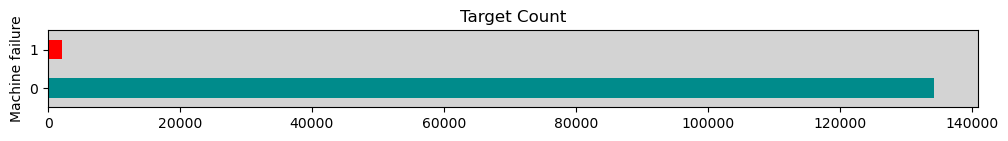

In [8]:
train  = df_train.copy()
test   = df_test.copy()
target = train.pop('Machine failure')

target.value_counts().plot(kind='barh', figsize=(12,1), title='Target Count', color=['darkcyan','red'])
plt.gca().set_facecolor('lightgray')

pd.DataFrame(data= {'Number': target.value_counts(), 'Percent': target.value_counts(normalize=True)})

In [9]:
features = train.columns.tolist()

# Categorical features
cat_features = ['Product ID', 'Type']

# Binary features
bin_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Numerical features
num_features = [f for f in features if f not in (cat_features + bin_features)]
              
print(':' * 40)
print('The number of Categorical_features:', len(cat_features)) 
print('The number of Binary_features:', len(bin_features))  
print('The number of Numerical_features:', len(num_features)) 
print(':' * 40)
print('The total number of features:', len(features))
print(':' * 40)

::::::::::::::::::::::::::::::::::::::::
The number of Categorical_features: 2
The number of Binary_features: 5
The number of Numerical_features: 5
::::::::::::::::::::::::::::::::::::::::
The total number of features: 12
::::::::::::::::::::::::::::::::::::::::


In [10]:
for f in cat_features:
    
    print('\t' , f)
    n_f = train[f].value_counts()
    p_f = train[f].value_counts(normalize=True)
    display(pd.DataFrame(data= {'Number': n_f, 'Percent': p_f}))

	 Product ID


,Number,Percent
Product ID,,
L53257,139,0.001019
L49056,131,0.000960
L53271,131,0.000960
L54275,120,0.000880
L48892,120,0.000880
...,...,...
M24614,1,0.000007
H39399,1,0.000007
M15853,1,0.000007


	 Type


,Number,Percent
Type,,
L,95354,0.698928
M,32152,0.235668
H,8923,0.065404


In [11]:
dfv = pd.DataFrame(data= {'Value': ['Number 0', 'Percent 0', '', 'Number 1', 'Percent 1']})

for f in bin_features: 
    n_f = train[f].value_counts()
    p_f = train[f].value_counts(normalize=True)
    dfv[f] = [n_f[0], p_f[0], '', n_f[1], p_f[1]]
    
dfv.set_index('Value')

,TWF,HDF,PWF,OSF,RNF
Value,,,,,
Number 0,136217,135725,136102,135889,136121
Percent 0,0.998446,0.99484,0.997603,0.996042,0.997742
,,,,,
Number 1,212,704,327,540,308
Percent 1,0.001554,0.00516,0.002397,0.003958,0.002258


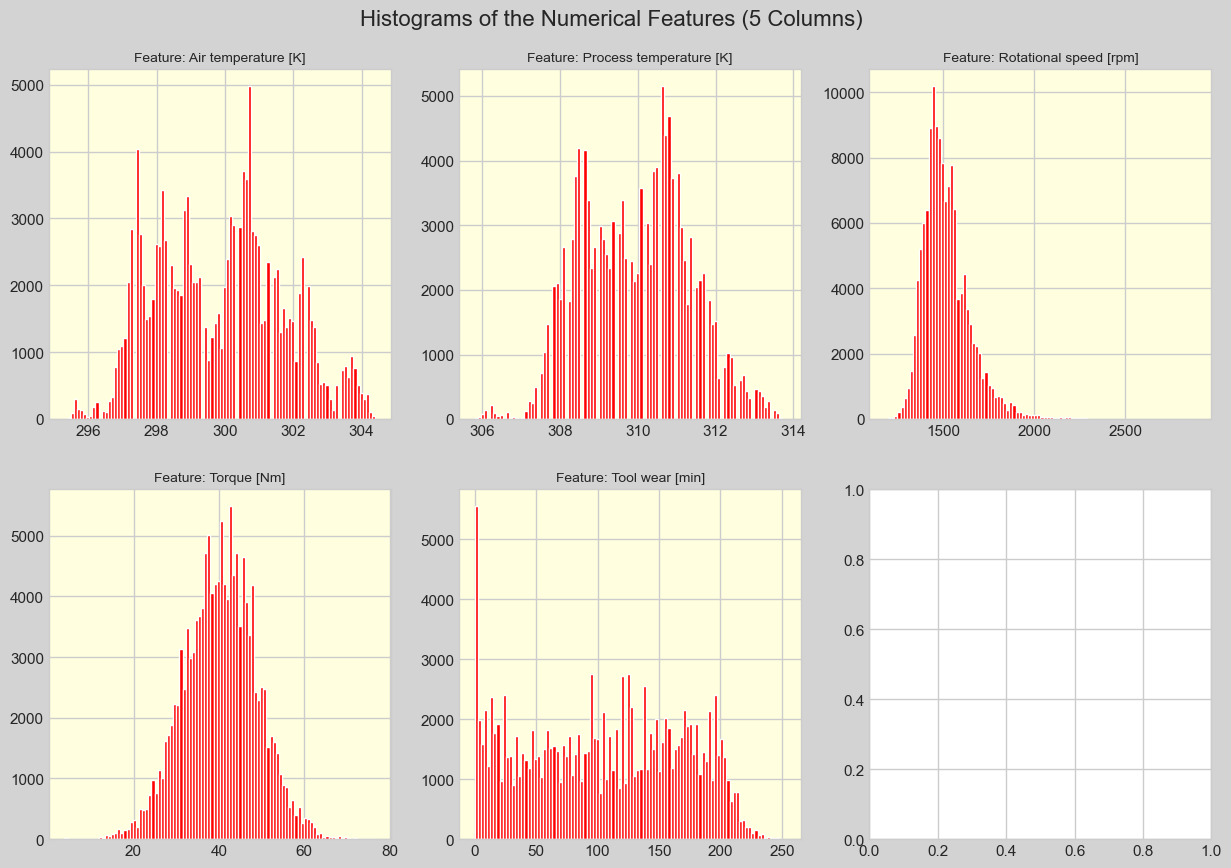

In [12]:
sns.set()
plt.style.use('seaborn-whitegrid') 
_, axs = plt.subplots(2, 3, figsize=(15,10), facecolor='lightgray')

for f, ax in zip(num_features, axs.ravel()):
    ax.set_facecolor('lightyellow')
    ax.hist(train[f], bins=100, color='red')
    ax.set_title(f'Feature: {f}', fontsize=10)

plt.suptitle('Histograms of the Numerical Features (5 Columns)', y=0.94, fontsize=16)
plt.show()

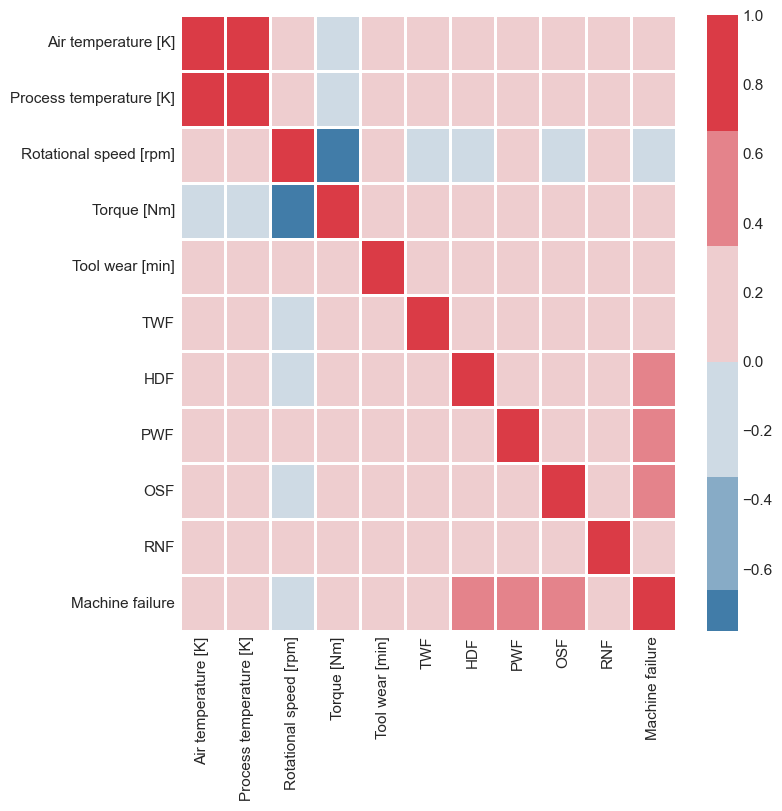

In [13]:
cor_matrix = df_train[num_features + bin_features  + ['Machine failure']].corr().round(2)
fig = plt.figure(figsize=(8,8));
# mask = np.zeros_like(cor_matrix)
# mask[np.triu_indices_from(mask)] = True
plt.gca().set_facecolor('lightyellow')

cmap=sns.diverging_palette(240, 10, s=75, l=50, sep=1, n=6, center='light', as_cmap=False);
sns.heatmap(cor_matrix, center=0, annot=False, cmap=cmap, mask=False, linewidths=2);
plt.show()

In [14]:
corr = df_train[num_features + bin_features  + ['Machine failure']].corr(numeric_only=True)
corr.style.background_gradient(cmap='Blues')

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
Air temperature [K],1.000000,0.856080,0.016545,-0.006773,0.016994,0.003826,0.100454,0.007967,0.007842,0.004815,0.067744
Process temperature [K],0.856080,1.000000,0.011263,-0.006298,0.012777,0.004459,0.041454,0.003871,0.005337,0.004399,0.030966
Rotational speed [rpm],0.016545,0.011263,1.000000,-0.779394,0.003983,-0.005765,-0.081996,0.053948,-0.061376,-0.003410,-0.060868
Torque [Nm],-0.006773,-0.006298,-0.779394,1.000000,-0.003148,0.012983,0.100773,0.050289,0.108765,0.007986,0.145793
Tool wear [min],0.016994,0.012777,0.003983,-0.003148,1.000000,0.046470,0.011709,0.007624,0.063604,-0.002071,0.056448
TWF,0.003826,0.004459,-0.005765,0.012983,0.046470,1.000000,0.010145,0.039927,0.036041,0.002044,0.311919
HDF,0.100454,0.041454,-0.081996,0.100773,0.011709,0.010145,1.000000,0.046680,0.067149,0.000885,0.564507
PWF,0.007967,0.003871,0.053948,0.050289,0.007624,0.039927,0.046680,1.000000,0.090016,0.000827,0.383941
OSF,0.007842,0.005337,-0.061376,0.108765,0.063604,0.036041,0.067149,0.090016,1.000000,-0.000539,0.494668
RNF,0.004815,0.004399,-0.003410,0.007986,-0.002071,0.002044,0.000885,0.000827,-0.000539,1.000000,0.001428


In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def roc_auc(true_list, pred_list, a, b):
    
    fpr, tpr, _ = roc_curve(true_list, pred_list)    
    roc_auc = auc(fpr, tpr)

    # print(f'FPR: {fpr}')
    # print(f'TPR: {tpr}')
    # print(f'{list(zip(fpr,tpr))}') 
    print(f'\n>>>>> ROC_AUC: %0.6f <<<<<\n' %roc_auc)
    
    sns.set()
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(a, b), facecolor='lightgray')
    plt.gca().set_facecolor('lightyellow')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The area under the ROC curve\n')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()

df_train[num_features] = scaler.fit_transform(df_train[num_features])
df_test[num_features] = scaler.fit_transform(df_test[num_features])

In [17]:
def fix_names(df):
    df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
    return df

df_train = fix_names(df_train)
df_test  = fix_names(df_test)
display(pd.DataFrame(data= {'Number': df_train['Product ID'].value_counts(), 'Percent': df_train['Product ID'].value_counts(normalize=True)}))

,Number,Percent
Product ID,,
L53257,139,0.001019
L49056,131,0.000960
L53271,131,0.000960
L54275,120,0.000880
L48892,120,0.000880
...,...,...
M24614,1,0.000007
H39399,1,0.000007
M15853,1,0.000007


In [18]:
df_train = df_train.drop(['Product ID'] , axis=1)
df_test = df_test.drop(['Product ID'] , axis=1)
features = df_train.columns.tolist()
features.remove('Machine failure')

# Categorical features
cat_features = ['Type']

# Binary features
bin_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Numerical features
num_features = [f for f in features if f not in (cat_features + bin_features)]

In [19]:
train_code = pd.get_dummies(df_train, columns=cat_features)
test_code = pd.get_dummies(df_test, columns=cat_features)
target = train_code.pop('Machine failure')

train_code.shape, test_code.shape, target.shape
((136429, 13), (90954, 13), (136429,))
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer

In [20]:
transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(train_code))

pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(train_code, target)

Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal')),
                ('gaussiannb', GaussianNB())])


>>>>> ROC_AUC: 0.948110 <<<<<



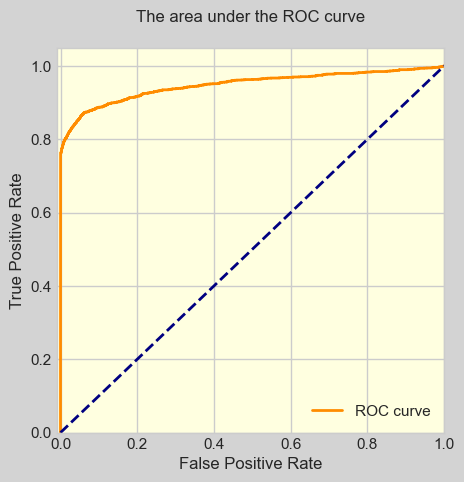

In [21]:
cross_val_score(pipeline, train_code, target, scoring='roc_auc', cv=10).mean()

roc_auc(target, pipeline.predict_proba(train_code)[:,1], 5, 5)

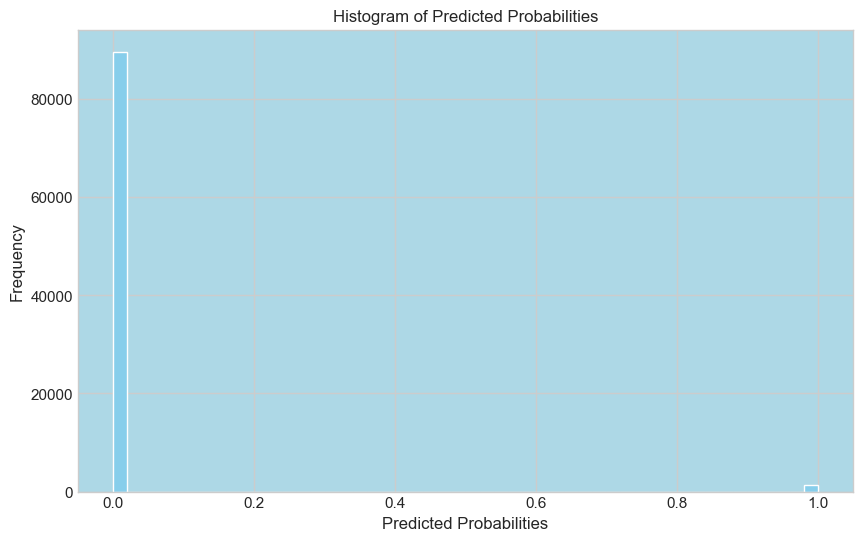

Min Predicted Probability: 8.927425010759776e-16
Max Predicted Probability: 1.0


In [22]:
preds_bayes = pipeline.predict_proba(test_code)[:,1]
preds_bayes



import matplotlib.pyplot as plt

# Assuming you have loaded or created preds_bayes array
plt.figure(figsize=(10, 6))
plt.hist(preds_bayes, bins=50, color='skyblue')
plt.gca().set_facecolor('lightblue')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()

print("Min Predicted Probability:", min(preds_bayes))
print("Max Predicted Probability:", max(preds_bayes))


In [23]:
sub_bayes = df_sample.copy()
sub_bayes['Machine failure'] = preds_bayes
sub_bayes.to_csv('submission_bayes.csv',index=False)
!ls

sub_import1 = pd.read_csv('/Users/abenapoku/input/failure-predictions/submission.csv')
sub_import2 = pd.read_csv('/Users/abenapoku/input/failure-predictions/submission.csv')
sub = df_sample.copy()
sub['Machine failure'] = (0.20 * sub_bayes['Machine failure']) + (0.10 * sub_import1['Machine failure']) + (0.70 * sub_import2['Machine failure'])
sub.to_csv('submission.csv',index=False)
!ls

MachineFailureRawcode.ipynb logisticRegression.ipynb
input                       sample_submission.csv
linearRegression.ipynb      submission_bayes.csv
MachineFailureRawcode.ipynb sample_submission.csv
input                       submission.csv
linearRegression.ipynb      submission_bayes.csv
logisticRegression.ipynb


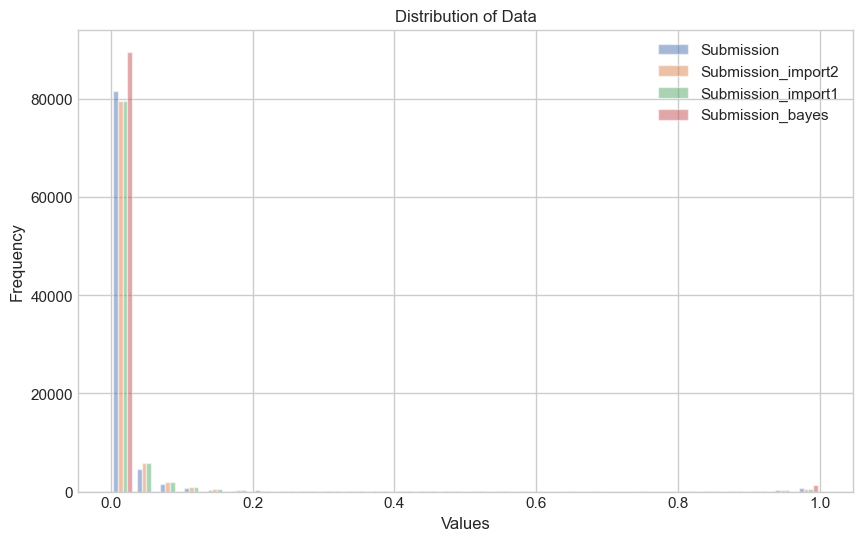

In [24]:
import matplotlib.pyplot as plt

hist_data = [sub.iloc[:, 1], sub_import2.iloc[:, 1], sub_import1.iloc[:, 1], sub_bayes.iloc[:, 1]]
group_labels = ['Submission', 'Submission_import2', 'Submission_import1', 'Submission_bayes']

plt.figure(figsize=(10, 6))
plt.hist(hist_data, bins=30, alpha=0.5, label=group_labels)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Load data
df_train = pd.read_csv('/Users/abenapoku/input/test-playground/train.csv', index_col='id')
df_test = pd.read_csv('/Users/abenapoku/input/test-playground/test.csv', index_col='id')
df_org = pd.read_csv('/Users/abenapoku/input/failure-predictions/machine failure.csv')

# Handle missing values
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)

# Separate features and target variable
X = df_train.drop('Machine failure', axis=1)
y = df_train['Machine failure']

# One-hot encode categorical features
cat_features = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_features, drop_first=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42)

# Define function to plot ROC curve and print ROC AUC score
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    print(f"ROC AUC Score ({model_name}): {roc_auc:.4f}")

#Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, rf_pred_proba, "Random Forest")

# Logistic Regression
logit_model = LogisticRegression(solver='liblinear', random_state=42)
logit_model.fit(X_train, y_train)
logit_pred_proba = logit_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, logit_pred_proba, "Logistic Regression")

# Random Forest


# Confusion Matrix and Classification Report for Logistic Regression
logit_pred = logit_model.predict(X_test)
print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, logit_pred))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, logit_pred))


# Confusion Matrix and Classification Report for Random Forest
rf_pred = rf_model.predict(X_test)
print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, rf_pred))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_pred))
